In [1]:
# path = 'Potholes/annotated-images/'
# splits = 'Potholes/splits.json'

path = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/annotated-images/'
splits = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/splits.json'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.ops import RoIAlign
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as Fs
from torchvision import transforms as v2
import torchvision.ops as ops
import torch
import json
from xml.etree import ElementTree as ET
from torch.utils.data import DataLoader
from torchvision.io import decode_image
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split

# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(8)

def selective_search(image_path, num_rects, quality=True):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    image = cv2.imread(image_path)
    ss.setBaseImage(image)
    
    if quality:
        ss.switchToSelectiveSearchQuality()
    else:
        ss.switchToSelectiveSearchFast()
        
    rects = ss.process()

    return rects[:num_rects]


def show_selective_search(image, rects):
    imOut = image.copy()

    # itereate over all the region proposals
    for _, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)

    plt.imshow(imOut[...,::-1])
    plt.axis('off')


def read_xml(path: str) -> list:  
    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)
    
    return obj_list

def collate_fn(batch):
    return tuple(zip(*batch))

def visualize_boxes(images, annotations):
    all_images = []
    all_overlay = []

    for image, annotation in zip(images, annotations):
        
        overlay = draw_bounding_boxes(image, annotation, width=2)
        all_images.append(image)
        all_overlay.append(overlay)
    
    fig, axes = plt.subplots(len(all_images), 2, figsize=(10, len(all_images) * 5))
    
    for idx, image in enumerate(all_images):
        axes[idx, 0].imshow(image.permute(1,2,0))
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(all_overlay[idx].permute(1,2,0))
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()
        


#Pretrained R-CNN
class RCNN(nn.Module):
    def __init__(self, num_classes, backbone='resnet50', pretrained=False):
        super(RCNN, self).__init__()
        
        # Resnet50 as backbone for the pretrained R-CNN model
        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Removing last FC layer
            
        # feature map size from backbone for RoI Pooling
        self.output_channels = 2048 
        
        # RoI Pooling Layer
        self.roi_pool = RoIAlign((7, 7), spatial_scale=1.0, sampling_ratio=-1) 
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.output_channels * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)  
        )
        
        # Bounding Box Regressor Head
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.output_channels * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4)  
        )
    
    def forward(self, images, rois):
        feature_maps = self.backbone(images)
        roi_features = self.roi_pool(feature_maps, rois)
        roi_features = roi_features.view(roi_features.size(0), -1)
        class_logits = self.classifier(roi_features)
        bbox = self.bbox_regressor(roi_features)
        return class_logits, bbox


# Used as backbone
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define custom convolutional layers as per the framework
        self.convolutional1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convolutional2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convolutional3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convolutional4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        x = self.convolutional4(x)
        return x

class homebrew_RCNN(nn.Module):
    def __init__(self, num_classes):
        super(homebrew_RCNN, self).__init__()
        
        self.backbone = CNN()
        self.output_channels = 512  # Output channels of the last convolutional layer

        # RoI Pooling Layer
        self.roi_pool = RoIAlign((7, 7), spatial_scale=1.0, sampling_ratio=-1)
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.output_channels * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes) 
        )
        
        # Bounding Box Regressor Head
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.output_channels * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4)  # Bounding box values
        )
    
    def forward(self, images, rois):
        # Extract feature maps from the backbone
        feature_maps = self.backbone(images)
        
        # Apply RoI Pooling on feature maps using the provided rois
        roi_features = self.roi_pool(feature_maps, rois)
        roi_features = roi_features.view(roi_features.size(0), -1)
        
        # Get classification logits and bounding box predictions
        class_logits = self.classifier(roi_features)
        bbox= self.bbox_regressor(roi_features)
        
        return class_logits, bbox



In [3]:
def resize_with_padding(image, target_size=(256, 256)):
    original_height, original_width = image.shape[1], image.shape[2]
    target_height, target_width = target_size
    
    # Calculate aspect ratio and resize while maintaining aspect ratio
    aspect_ratio = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * aspect_ratio)
    new_height = int(original_height * aspect_ratio)
    
    # Resize image using bilinear interpolatior
    image_resized = F.interpolate(image.unsqueeze(0).float(), size=(new_height, new_width), mode='bilinear', align_corners=False).squeeze(0).byte()
    
    # black padding
    padded_image = torch.zeros((3, target_height, target_width), dtype=torch.uint8)
    padding_top = (target_height - new_height) // 2
    padding_left = (target_width - new_width) // 2
    padded_image[:, padding_top:padding_top+new_height, padding_left:padding_left+new_width] = image_resized
    
    return padded_image, padding_top, padding_left, aspect_ratio

def adjust_bboxes_with_padding(bboxes, padding_top, padding_left, aspect_ratio):
    bboxes[:, [0, 2]] *= aspect_ratio  
    bboxes[:, [1, 3]] *= aspect_ratio  
    
    bboxes[:, 0] += padding_left  
    bboxes[:, 1] += padding_top   
    bboxes[:, 2] += padding_left  
    bboxes[:, 3] += padding_top   
    
    return bboxes

import torch
import torchvision.ops as ops

class Pothole_Dataloader(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, num_rects=1000, pos_thresh=0.5, neg_thresh=0.3, size=256, val=False, device="cpu"):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_rects = num_rects
        self.pos_thresh = pos_thresh
        self.neg_thresh = neg_thresh
        self.size = size
        self.val = val
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = decode_image(self.image_paths[idx])
        
        # Resize and padding image
        image_resized, padding_top, padding_left, aspect_ratio = resize_with_padding(image, target_size=(self.size, self.size))

        boxes = read_xml(self.mask_paths[idx])  
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # For sanity.. 
        boxes = ops.box_convert(boxes, in_fmt="xyxy", out_fmt="xyxy")  

        boxes = adjust_bboxes_with_padding(boxes, padding_top, padding_left, aspect_ratio)

        if not self.val:
            regions = torch.tensor(selective_search(self.image_paths[idx], self.num_rects, quality=False), dtype=torch.float32)
            regions = ops.box_convert(regions, in_fmt="xywh", out_fmt="xyxy")
            regions = adjust_bboxes_with_padding(regions, padding_top, padding_left, aspect_ratio)

            ious = ops.box_iou(regions.to(self.device), boxes.to(self.device))

            # Select proposals with IoU >= pos_thresh as positive samples
            pos_indices = (ious.max(dim=1)[0] >= self.pos_thresh).nonzero(as_tuple=True)[0]
            pos_samples = regions[pos_indices]
            # Select proposals with IoU < neg_thresh as background samples
            bg_indices = (ious.max(dim=1)[0] < self.neg_thresh).nonzero(as_tuple=True)[0]
            num_bg = int(len(pos_samples) * 4)  # Background samples 80% of total proposals
            bg_samples = regions[bg_indices[:num_bg]]

            # Concatenate positive and background samples
            selected_regions = torch.cat([pos_samples, bg_samples], dim=0)
            region_labels = torch.cat([torch.ones(len(pos_samples)), torch.zeros(num_bg)])

            return image_resized, boxes, regions, selected_regions, region_labels
        
        # else:
            
        #     return image_resized, boxes, [], [], []
        else:
            regions = selected_regions = region_labels = []
    
        return image_resized, boxes, regions, selected_regions, region_labels


train_mask_list = [path + f for f in json.load(open(splits))['train']]
val_mask_list = [path + f for f in json.load(open(splits))['test']]
train_img_list = [filename.replace('xml', 'jpg') for filename in train_mask_list]
val_img_list = [filename.replace('xml', 'jpg') for filename in val_mask_list]

In [ ]:
size = 512 #image size 
batch_size = 32
num_workers = 1

val_img_list, test_img_list, val_mask_list, test_mask_list = train_test_split(val_img_list, val_mask_list, train_size=.5)

trainset = Pothole_Dataloader(train_img_list, train_mask_list, size=size, val=False)
valset = Pothole_Dataloader(val_img_list, val_mask_list, size=size, val=True)
testset = Pothole_Dataloader(test_img_list, test_mask_list, size=size, val=True)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader= DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [5]:
images, boxes, regions, selected_regions, region_labels = next(iter(train_loader))

In [6]:
images[0].shape

torch.Size([3, 512, 512])

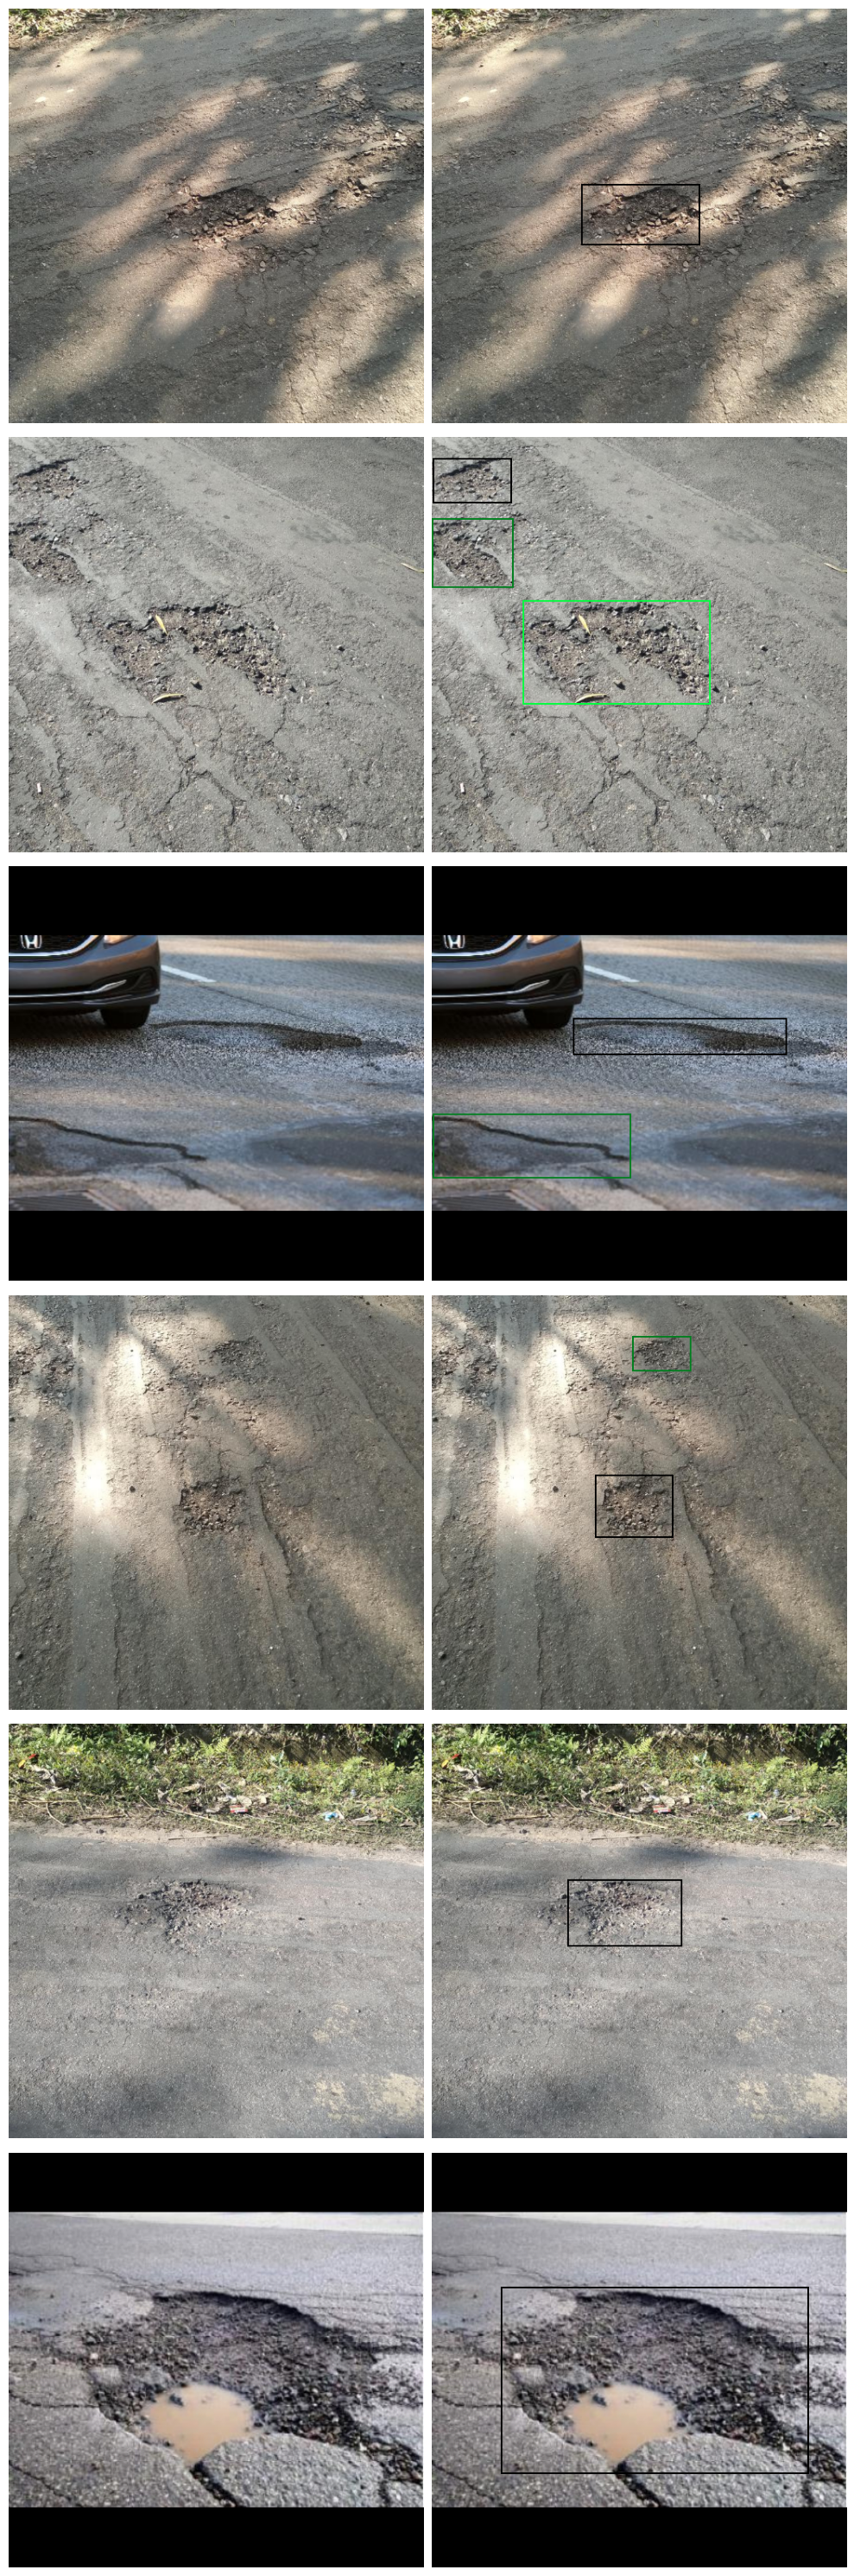

In [7]:
visualize_boxes(images, boxes)
#visualize_boxes(images, selected_regions)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = homebrew_RCNN(num_classes=2) 
#model = RCNN(num_classes=2) # pre-trained
model.to(device)


classification_loss = nn.CrossEntropyLoss() # For classification (maybe change to BCE but its fine)
regression_loss = nn.SmoothL1Loss() # For regression (MSE = L1, so an enhanced version)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 2


# Training loop that works with the current setup of dataloader for both homebrew and pretrained R-CNN. 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for images, boxes, regions, selected_regions, region_labels in pbar:

            # Convert tuple images to tensor batch
            images = torch.stack(images).to(device)
            images = images.float() / 255.0 # normalizing (caused issue by not doing it)

            region_labels = [label.to(device) for label in region_labels]  

            """
            process a list of ROIs and their corresponding labels from multiple images. 
            For each image:
            It concat the image index with the ROI coordinates to create a unified representation of each ROI.
            It then appends the newly created ROIs and their labels to separate lists for further processing.
            """
            rois = []
            roi_labels = []


            for img_idx, (img_regions, img_labels) in enumerate(zip(selected_regions, region_labels)):
                img_rois = torch.cat([torch.full((img_regions.size(0), 1), img_idx, dtype=torch.float32), img_regions.float()], dim=1)
                rois.append(img_rois)
                roi_labels.append(img_labels)

            rois = torch.cat(rois, dim=0).to(device) 
            spatial_scale_factor = 1 / 32 # scale factor to adjust the ROI coordinates based on the downsampling of the feature map (RCNN)
            rois[:, 1:] *= spatial_scale_factor # rescales the ROI coordinates
            roi_labels = torch.cat(roi_labels, dim=0).to(device) 

            optimizer.zero_grad()
            class_logits, bbox_deltas = model(images, rois)

            loss_cls = classification_loss(class_logits, roi_labels.long())  # roi_labels had to be .long() didn't look into why. 
            loss_reg = regression_loss(bbox_deltas, rois[:, 1:])  # Compare to ground truth rois

            total_loss = loss_cls + loss_reg
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/2: 100%|██████████| 89/89 [16:36<00:00, 11.20s/batch, loss=4.3] 


Epoch [1/2], Loss: 4.2980


Epoch 2/2: 100%|██████████| 89/89 [17:04<00:00, 11.51s/batch, loss=3.25]

Epoch [2/2], Loss: 3.2500
